# CNNs for lung cancer detection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn import metrics

DATA_PATH = 'data/lung_image_sets'
IMG_SIZE = 256
SPLIT_RATIO = 0.2
EPOCHS = 10
BATCH_SIZE = 64

# Load and display sample images from each category
def display_sample_images(classes, path):
    for category in classes:
        image_dir = f'{path}/{category}'
        images = os.listdir(image_dir)

        # Create subplots for each category
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Sample Images for {category}', fontsize=20)

        # Display 3 random images from each category
        for i in range(3):
            img = np.array(Image.open(f'{image_dir}/{images[np.random.randint(0, len(images))]}'))
            ax[i].imshow(img)
            ax[i].axis('off')
        plt.show()

# Preprocess images: resize and store in arrays
def load_images(classes, path, img_size):
    X, Y = [], []
    for i, category in enumerate(classes):
        image_paths = glob(f'{path}/{category}/*.jpeg')
        print(f'Loading images for {category}... ({len(image_paths)} images)')

        for image_path in image_paths:
            img = cv2.imread(image_path)
            X.append(cv2.resize(img, (img_size, img_size)))
            Y.append(i)  # Append the class label
    return np.asarray(X), pd.get_dummies(Y).values  # One-hot encode Y

Function to create the model

In [2]:
def create_model(img_size):
    model = keras.models.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', input_shape=(img_size, img_size, 3), padding='same'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')  # 3 output categories
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Callback to stop training when validation accuracy exceeds 90%
class StopAt90Accuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print('\nReached 90% validation accuracy. Stopping training.')
            self.model.stop_training = True

Function to train the model

In [3]:
def train_model(model, X_train, Y_train, X_val, Y_val, batch_size, epochs):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

    # Train the model with callbacks
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=batch_size, epochs=epochs, verbose=1, 
                        callbacks=[reduce_lr, StopAt90Accuracy()])
    
    return history

Function to plot training history

In [4]:
def plot_training_history(history):
    history_data = pd.DataFrame(history.history)
    
    # Plot loss
    history_data[['loss', 'val_loss']].plot(title='Loss', figsize=(10, 5))
    plt.show()
    
    # Plot accuracy
    history_data[['accuracy', 'val_accuracy']].plot(title='Accuracy', figsize=(10, 5))
    plt.show()

Function to evaluate the model 

In [5]:
def evaluate_model(model, X_val, Y_val, classes):
    Y_pred = model.predict(X_val)
    
    # Convert predictions and true values from one-hot encoding to class labels
    Y_val_labels = np.argmax(Y_val, axis=1)
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    
    # Print classification report
    print(metrics.classification_report(Y_val_labels, Y_pred_labels, target_names=classes))

    confusion_matrix = metrics.confusion_matrix(Y_val_labels, Y_pred_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

Display images

Classes found: ['lung_aca', 'lung_scc', 'lung_n']


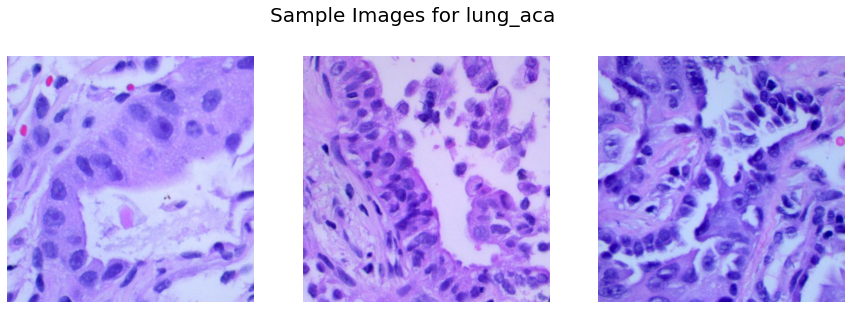

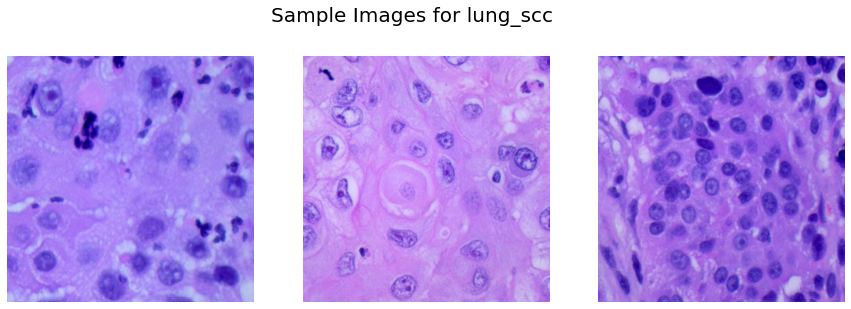

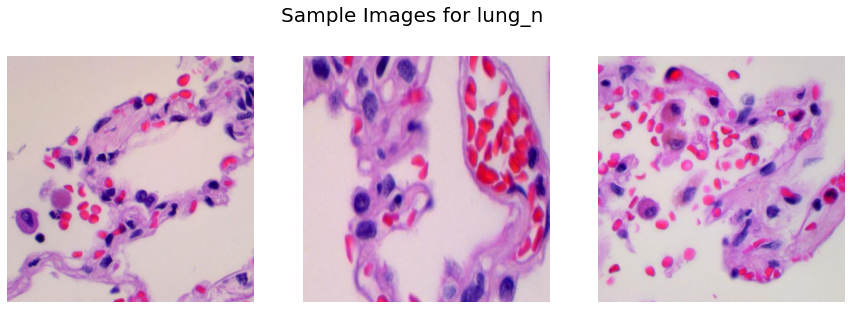

In [6]:
classes = os.listdir(DATA_PATH)
print(f'Classes found: {classes}')

# Display sample images
display_sample_images(classes, DATA_PATH)

Load the data

In [18]:
# Load and preprocess images
X, Y = load_images(classes, DATA_PATH, IMG_SIZE)
    
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=SPLIT_RATIO, random_state=42)
print(f'Training data: {X_train.shape}, Validation data: {X_val.shape}')

Loading images for lung_aca... (2000 images)
Loading images for lung_scc... (2000 images)
Loading images for lung_n... (2000 images)
Training data: (4800, 256, 256, 3), Validation data: (1200, 256, 256, 3)


Create the model

In [7]:
model = create_model(IMG_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

Train the model

In [26]:
history = train_model(model, X_train, Y_train, X_val, Y_val, BATCH_SIZE, EPOCHS)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 525s 7s/step - accuracy: 0.7520 - loss: 0.5894 - val_accuracy: 0.4433 - val_loss: 4.5709 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 535s 7s/step - accuracy: 0.8762 - loss: 0.3048 - val_accuracy: 0.3642 - val_loss: 266.6496 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 527s 7s/step - accuracy: 0.8774 - loss: 0.2980 - val_accuracy: 0.6933 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 564s 7s/step - accuracy: 0.9211 - loss: 0.2065 - val_accuracy: 0.8892 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 563s 8s/step - accuracy: 0.9507 - loss: 0.1356 - val_accuracy: 0.4725 - val_loss: 5.9583 - learning_rate: 0.0010
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9693 - loss: 0.0868
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.9694 - loss: 0.0867 - val_accu

Plot the results

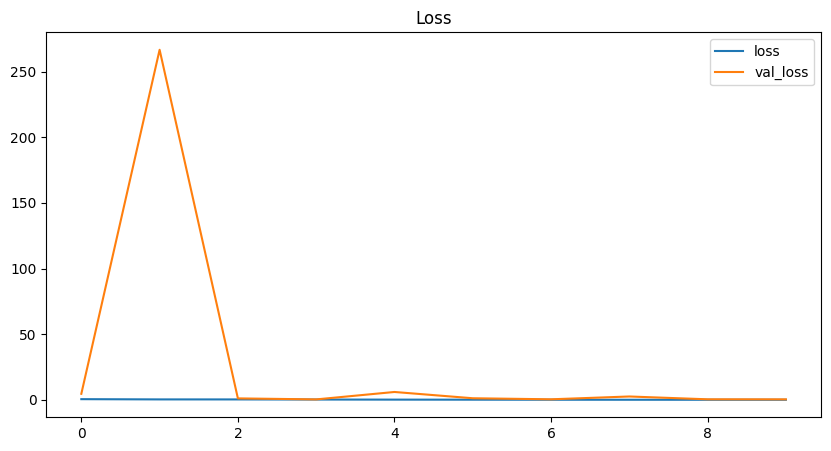

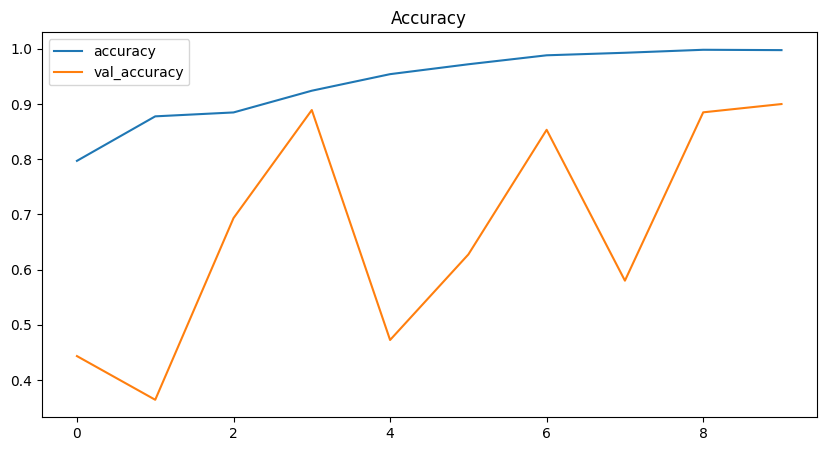

In [45]:
plot_training_history(history)

Evaluate the results

38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 936ms/step
              precision    recall  f1-score   support

    lung_aca       0.94      0.78      0.85       437
    lung_scc       0.80      0.95      0.87       380
      lung_n       0.99      0.99      0.99       383

    accuracy                           0.90      1200
   macro avg       0.91      0.91      0.90      1200
weighted avg       0.91      0.90      0.90      1200



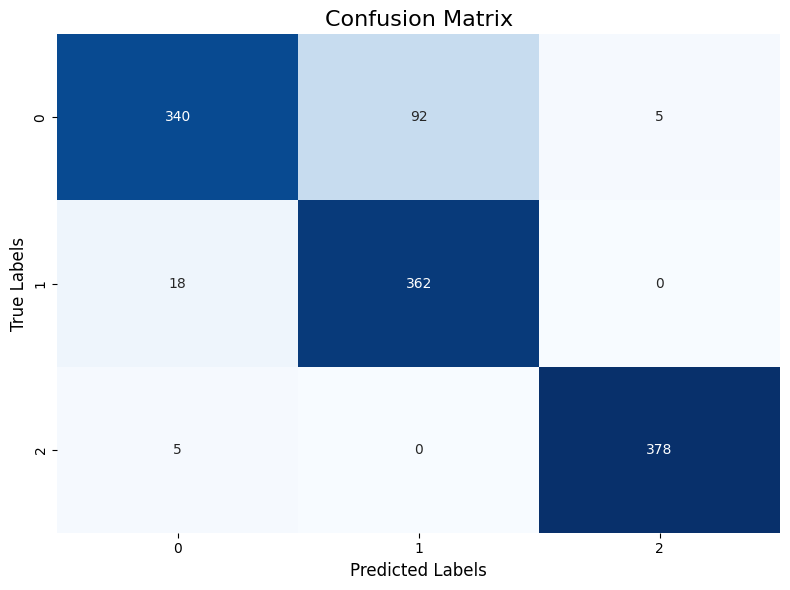

In [53]:
evaluate_model(model, X_val, Y_val, classes)